# LEEP 2024 Multi-Country CEA

Since conducting its first paint study in Malawi in late 2020, LEEP has significantly expanded and is now running lead paint elimination programs. We created an [updated cost-effectiveness analysis](https://my.causal.app/models/212624?token=97c447ae91e74281b8032591b190e316) (CEA) that accounts for our activity across 13 established program countries. In addition to incorporating multiple countries into the analysis, this new CEA also includes improvements to our original estimation strategy and updates to several input values. A conceptual overview of our estimation strategy for this updated CEA is included in the figure below.

This multi-country CEA includes the following updates relative to our original [Malawi CEA](https://docs.google.com/document/d/1abacbjeGakkmsZL3D7w1S0yadIgCl6ObfEl7sCVNpww/edit):

- Predicts the number of individuals born into homes with lead paint annually by estimating (a) number of homes painted annually, and (b) the proportion of newly painted homes that use lead paint
- Predicts the overall health impacts of lead paint exposure using an estimate for the average increase in an child's blood lead level (BLL) caused by living in a home with lead paint
- Includes a multiplier in the estimate of total health [disability-adjusted life years](https://www.who.int/data/gho/indicator-metadata-registry/imr-details/158) (DALYs) averted in order to adjust for new analysis of the cardiovascular effects associated with lead exposure
- Estimates government costs based on the projected amount of staff time (full-time equivalents) that will be required to implement/enforce lead paint regulation sooner than in the counterfactual scenario

Using our multi-country CEA, we estimate that LEEP's paint programs will avert one disability-adjusted life year-equivalent (DALY-equivalent) for $4.49 (90% confidence interval: 0.82 - 12.93 $/DALY-equivalent averted).

Ultimately, we find that our results are highly sensitive to a number of inputs, including the annual time discount rate, % earnings loss per point of IQ loss, IQ loss per BLL increase, average increase in BLL from living in a home with lead paint, growth in the paint market, years of income equivalent to 1 DALY, and % of new painted homes that use coloured solvent-based paint. Whilst we estimate these to the best of our ability with the information that we have available, as outlined in this document, we remain highly uncertain about their true values. We acknowledge that variations in these input values could have relatively large impacts on the value of our final estimate, and explore these effects in our [sensitivity analysis](https://docs.google.com/spreadsheets/d/1PeNSD1pqSQWF2afvQM0dIj1C-UcRHh4XGU_OmmjstZ4/edit#gid=0). We hope that over time, as we gather more experience and data, we will be able to hone these input values and increase the accuracy of our model and estimation methodologies.

This document describes the inputs into our multi-country CEA, and the data and estimation strategies that they are based on. By explaining our process for deriving input estimates and highlighting key uncertainties within our model, we hope to provide the context necessary to interpret our cost-effectiveness estimate in a reasonable and meaningful way.


In [1]:
import numpy as np
import pandas as pd
import squigglepy as sq
from squigglepy.numbers import K

pd.set_option('display.float_format', lambda x: f'{x:,.3f}')
idx = pd.IndexSlice

sq.set_seed(42)

COUNTRIES = ["Malawi", "Madagascar", "Sierra Leone", "Liberia", "Angola", "Pakistan",
             "Niger", "Zimbabwe", "Bolivia", "Ghana", "Nigeria", "Cote d'Ivoire", "Senegal"]
SCENARIOS = ["Counterfactual", "LEEP intervention"]
YEARS = range(2021, 2101)

N = 1*K
SAMPLES = range(N)

SAMPLE_YEAR_INDEX = pd.MultiIndex.from_product(
    [SAMPLES, YEARS], names=["Sample", "Year"])
SCENARIO_SAMPLE_INDEX = pd.MultiIndex.from_product(
    [SCENARIOS, SAMPLES], names=["Scenario", "Sample"])
SCENARIO_SAMPLE_YEAR_INDEX = pd.MultiIndex.from_product(
    [SCENARIOS, SAMPLES, YEARS], names=["Scenario", "Sample", "Year"])

## Inputs

### Population

The population and projected future population estimates for each country are from the [UN population projections](https://population.un.org/wpp/Download/Standard/CSV/).

In [2]:
# TODO(drw): Could use uncertainty estimates here?
population = pd.read_csv('population.csv', index_col=0)

### Births

Projections of future annual births in each country are from the [UN population projections](https://population.un.org/wpp/Download/Standard/Population/).

In [3]:
# TODO(drw): Could use uncertainty estimates here?
births = pd.read_csv('births.csv', index_col=0)

### Decline in lead market share once enforcement/compliance begins

We estimate that, once enforcement/compliance begins, the market share captured by lead-based paint will decline at a rate of 20% annually. This is a conservative estimate relative to our compliance goal: in the majority of our target countries, we aim to achieve 50% compliance a year after regulation is implemented and enforcement begins. [Follow up study](https://leadelimination.org/malawi-follow-up-study/) data from Malawi suggests that our compliance goals are achievable, as do preliminary reports of manufacturers representing >50% of market share switching to lead-free alternatives in Pakistan, Ghana, and Zimbabwe.

In [4]:
decline_in_lead_market_share_once_enforcement_compliance_begins = pd.Series(
    sq.norm(-0.3, -0.1, rclip=0) @ N)

### % of new painted homes that use some colored solvent based lead paint

To develop this estimate, we surveyed members of the LEEP team to understand their best guess of the portion of homes that use some coloured solvent-based paints in the countries where they work. We averaged the estimates provided by LEEP's team members, which gave us the estimate that coloured solvent-based paint is used in 80% of new painted homes in the LMICs included in this model. We are uncertain of this estimate given the difficulty of approximating this input across the variety of painting practices used in LMICs.

In [5]:
# TODO(drw): Why is this different from below?
pct_of_new_painted_homes_that_use_some_colored_solvent_based_lead_paint = pd.Series(
    sq.lognorm(0.65, 0.9) @ N)

### Lead market share of colored solvent based paints (2021)

For each country, we estimate the proportion of paint within the coloured solvent-based paint market that has a lead concentration greater than 90 parts per million (ppm). Estimates are primarily based on studies conducted by LEEP and by [IPEN](https://ipen.org/) that evaluate lead content among paints produced and sold within a given country. We use domestic and regional industry data to inform our estimates for countries in which a formal paint study has not been conducted. We adjust estimates slightly to reflect any information available about the relative market share of different brands within a given country. It is possible that we overestimate the value of this input because the paint studies that inform this estimate primarily test yellow and red paints, which are more likely to contain lead than other coloured paints, such as blue paint.

In [6]:
lead_market_share_of_colored_solvent_based_paints_2021 = pd.DataFrame(
    np.array(
        [sq.lognorm(0.60, 0.83, rclip=1) @ N,
         sq.lognorm(0.60, 0.83, rclip=1) @ N,
         sq.lognorm(0.32, 0.44, rclip=1) @ N,
         sq.lognorm(0.60, 0.83, rclip=1) @ N,
         sq.lognorm(0.48, 0.66, rclip=1) @ N,
         sq.lognorm(0.52, 0.72, rclip=1) @ N,
         sq.lognorm(0.32, 0.44, rclip=1) @ N,
         sq.lognorm(0.52, 0.72, rclip=1) @ N,
         sq.lognorm(0.32, 0.44, rclip=1) @ N,
         sq.lognorm(0.16, 0.22, rclip=1) @ N,
         sq.lognorm(0.68, 0.94, rclip=1) @ N,
         sq.lognorm(0.60, 0.83, rclip=1) @ N,
         sq.lognorm(0.60, 0.83, rclip=1) @ N]).T,
    columns=COUNTRIES)

### Annual time discount rate

We discount future costs and benefits at a rate of 4% per year, in line with [GiveWell](https://docs.google.com/spreadsheets/d/1B1fODKVbnGP4fejsZCVNvBm5zvI1jC7DhkaJpFk6zfo/edit#gid=1362437801). There is debate over the appropriate discount rate. [Haacker, Hallett, and Atun (2020)](https://academic.oup.com/heapol/article/35/1/107/5591528) found that 85% of 188 global health CEAs used a discount of 3% for both health and costs. Given the 100-year timeframe of this model, this is an important factor (e.g. a value of 1 in year 1 discounted by 4% per year would be 0.46 in year 20, 0.14 in year 50, and 0.06 by year 70; whereas using a discount rate of 3% would give a value of 0.55 in year 20, 0.23 in year 50, and 0.13 by year 70).

In [7]:
annual_time_discount_rate = pd.Series(sq.norm(0.03, 0.05, lclip=0) @ N)

### Discount factor

In [8]:
discount_factor = pd.Series(
    np.array([1/(1 + annual_time_discount_rate)**(year - YEARS[0])
             for year in YEARS]).T.flatten(),
    index=SAMPLE_YEAR_INDEX)

### Increase in BLL from living in a home with lead paint

We estimate that in LMICs, child blood lead levels increase on average by 1.7 ug/dL (90% intuitive confidence interval: [0.7, 3]) as a result of growing up in a home with lead paint. We note that in estimating the average increase in BLL from living in a home with lead paint, we are calculating the average effect: individual effect sizes observed on a case-by-case empirical basis could vary greatly from this average. With our estimate, we are simply aiming to capture the mean of these variable effect sizes. Similarly, the 90% intuitive confidence interval presented is a confidence interval for the average effect size, and does not characterise the distribution of individual effects that could be observed in practice. 

Our estimate comes from reviewing the literature, and is primarily based on the results of [Lanphear et al. (1998)](https://www.sciencedirect.com/science/article/pii/S0013935197938019?via%3Dihub), [Clark et al. (2011)](https://www.researchgate.net/publication/49706881_Effects_of_HUD-supported_lead_hazard_control_interventions_in_housing_on_children's_blood_lead), [Dixon et al. (2005)](https://www.sciencedirect.com/science/article/abs/pii/S0013935105000216), and [Dixon et al. (2009)](https://ehp.niehs.nih.gov/doi/full/10.1289/ehp.11918). We note that none of the existing studies that we were able to find specifically isolate the primary, causal effect on childrens' blood lead levels of growing up in a home with lead paint (e.g. by failing to control for other environmental sources of lead exposure, or only looking at the secondary effect of abatement interventions), and so we are highly uncertain in our final estimate. Our choice of 1.7 ug/dL is likely to be an underestimate, which we have chosen in order to be conservative, especially because our final cost-effectiveness estimate is highly sensitive to this input. More detail on the methodology used to calculate this figure can be found in our [BLL one-pager](https://docs.google.com/document/d/1fwwxFqoSc85qlqteRAm2gQa6JXaKAZisFjjBPmQSlKM/edit).

In [9]:
increase_in_bll_from_living_in_a_home_with_lead_paint = pd.Series(
    sq.norm(0.7, 3.0, lclip=0) @ N)

### Implied % of childhood BLL caused by lead paint initially

In [10]:
# TODO(drw): This formula references non-inputs

### Probability of success

We calculate a probability of success for each country, which encapsulates our estimate of the likelihood that our intervention that country is likely to succeed in its implementation, and hence that its associated benefits will be realised. These figures were estimated by the LEEP team based on knowledge of each country and an assessment of current progress towards implementation in each country. Overall, our probability of success estimates are relatively high, since they mostly capture the “stochastic' possibility of failure due to events such as unexplained government withdrawal / reversal, or political instability, which we feel to be relatively unlikely. The possibility of implementation being delayed, on the other hand, is already captured in our uncertainty intervals around intervention start dates.

We multiply total discounted benefits by these probabilities of success to get total expected discounted benefits, and calculate the final cost-effectiveness number as total discounted costs divided by total expected discounted benefits. We choose only to weight benefits, and not costs, by the probabilities of success, in order to be conservative and reflect the possibility that failure occurs even despite government and LEEP costs having already been incurred.


In [11]:
# TODO(drw): These are probably all correlated to some degree (e.g. reputation risk or lead becomes politicized)
# TODO(drw): Also should use beta for percentages?
probability_of_success = pd.DataFrame(
    np.array(
        [sq.lognorm(0.85, 0.95, rclip=1) @ N,
         sq.lognorm(0.75, 0.85, rclip=1) @ N,
         sq.lognorm(0.70, 0.80, rclip=1) @ N,
         sq.lognorm(0.65, 0.75, rclip=1) @ N,
         sq.lognorm(0.75, 0.85, rclip=1) @ N,
         sq.lognorm(0.85, 0.95, rclip=1) @ N,
         sq.lognorm(0.70, 0.80, rclip=1) @ N,
         sq.lognorm(0.75, 0.85, rclip=1) @ N,
         sq.lognorm(0.70, 0.80, rclip=1) @ N,
         sq.lognorm(0.75, 0.85, rclip=1) @ N,
         sq.lognorm(0.75, 0.85, rclip=1) @ N,
         sq.lognorm(0.70, 0.80, rclip=1) @ N,
         sq.lognorm(0.70, 0.80, rclip=1) @ N]).T,
    columns=COUNTRIES)

## Births with averted lead paint exposure

### Number of homes painted

#### People per household

We use recent data on average household size from the [Global Data Lab](https://globaldatalab.org/areadata/table/hhsize/AGO+CIV+GHA+LBR+MDG+MWI+NER+NGA+SEN+SLE+ZWE+BOL+PAK/?levels=1+4). We assume that average household size will decrease at a constant rate of 1% annually across countries. Average household size in high income countries is approximately 2.5, thus we treat this value as a long term minimum assumption in our estimates. Our estimate for people per household is used to calculate the total number of homes within a country. Our model is relatively insensitive to this input because the proportion of homes exposed to lead paint has a greater effect on our final estimate of cost-effectiveness than the absolute number of homes within the country.

In [12]:
# TODO(drw): Would be easier to follow if calculations/descriptions were in the same order
PEOPLE_PER_HOUSEHOLD_INIT = pd.Series(
    [3.96,
     4.18,
     9.01,
     4.33,
     6.45,
     8.21,
     7.45,
     3.27,
     4.86,
     4.22,
     6.86,
     2.81,
     10.8],
    index=COUNTRIES)
PEOPLE_PER_HOUSEHOLD_MIN = 2.5
PEOPLE_PER_HOUSEHOLD_RATE = -0.01

people_per_household = pd.DataFrame(
    np.array(
        [np.maximum(
            PEOPLE_PER_HOUSEHOLD_INIT * (1 + PEOPLE_PER_HOUSEHOLD_RATE)**(year - YEARS[0]), PEOPLE_PER_HOUSEHOLD_MIN)
         for year in YEARS]),
    index=YEARS, columns=COUNTRIES)

#### Number of homes

In [13]:
number_of_homes = (population / people_per_household)

#### Growth in the paint market

We use data from a [variety of sources](https://docs.google.com/spreadsheets/d/1bIiee05WlPt4B7NV3uvol2vu5JVbwOvL/edit#gid=508218074)  – IndustryArc, European Coatings, and Emerald Group, among others – to calculate an initial paint market growth rate of 5.5%. We arrive at this estimate by considering the average of the paint market growth rates from these sources, which is 5.75%. However, these growth rates correspond to a range of different countries and regions, and reflect growth in the paint market as a whole, rather than in the portion of the market that is specifically captured by home-use paints. Therefore, to be more conservative, we choose 5.5% as the initial value in 2021. 5.5% is also in line with a 20-year average of the World Bank's estimate for real [GDP growth](https://data.worldbank.org/indicator/NY.GDP.MKTP.KD.ZG?locations=XO) in low- and middle-income countries (LMICs), which we would expect to approximate future GDP growth and correlate with paint market growth.

We assume that the paint market growth rate decreases by 0.03% per year (i.e. 5.5% in year 1, 5.47% in year 2). We expect that once all existing homes within a country are painted, then growth in the paint market will be roughly equal to population growth from that point forward. To reflect our expectation that growth in the paint market will converge with population growth in the long term, we treat the population growth rate in each country as the long term minimum for paint market growth.

This figure is a simplification in that we use one estimate of paint market growth rate for all countries within our model, rather than calculating unique growth rates for each country.


In [14]:
# TODO(drw): Modeling population(/housing) and paint growth independently?
GROWTH_IN_THE_PAINT_MARKET_INIT = pd.Series(sq.norm(0.025, 0.08, lclip=0) @ N)
GROWTH_IN_THE_PAINT_MARKET_RATE = -0.0003

growth_in_the_paint_market = pd.DataFrame(
    np.array(
        [GROWTH_IN_THE_PAINT_MARKET_INIT + GROWTH_IN_THE_PAINT_MARKET_RATE*(year - YEARS[0])
         for year in YEARS]).T,
    index=SAMPLES, columns=YEARS)

#### % population urban

We use UN population projections of urban populations to determine the proportion of each country's population that lives in an urban area. We use the UN's estimate for the urban percentage of the population in 2020.

In our Malawi CEA, we assumed that the proportion of homes that are painted is equal to the proportion of the population that lives in urban areas. In our current CEA, we update this starting assumption such that in Year 1, the proportion of homes that are painted is equal to the sum of 75% of the urban population and 25% of the rural (non-urban) population. In our model, the urban population percentage is only used to calculate the percentage of homes painted in Year 1 (2021). In future years, our estimate for the percentage of homes painted is calculated using a different formula that is primarily dependent on changes in the paint market growth rate, rather than urban population projections. We use this approach because we are uncertain about how urban-rural classification will correspond with home painting rates in future years. For example, it is possible that the proportion of homes painted in rural areas will increase significantly as countries continue to experience economic growth.


In [15]:
pct_population_urban = pd.DataFrame(
    np.array(
        [sq.lognorm(0.165, 0.183, rclip=1) @ N,
         sq.lognorm(0.371, 0.410, rclip=1) @ N,
         sq.lognorm(0.409, 0.452, rclip=1) @ N,
         sq.lognorm(0.494, 0.546, rclip=1) @ N,
         sq.lognorm(0.637, 0.704, rclip=1) @ N,
         sq.lognorm(0.353, 0.391, rclip=1) @ N,
         sq.lognorm(0.162, 0.179, rclip=1) @ N,
         sq.lognorm(0.304, 0.336, rclip=1) @ N,
         sq.lognorm(0.665, 0.735, rclip=1) @ N,
         sq.lognorm(0.542, 0.599, rclip=1) @ N,
         sq.lognorm(0.494, 0.546, rclip=1) @ N,
         sq.lognorm(0.494, 0.546, rclip=1) @ N,
         sq.lognorm(0.456, 0.504, rclip=1) @ N]).T,
    columns=COUNTRIES)

#### Number of painted homes

In [16]:
PCT_OF_HOMES_PAINTED_URBAN = 0.75
PCT_OF_HOMES_PAINTED_RURAL = 0.25
PCT_OF_HOMES_PAINTED_INIT = PCT_OF_HOMES_PAINTED_URBAN*pct_population_urban + \
    PCT_OF_HOMES_PAINTED_RURAL*(1 - pct_population_urban)

number_of_painted_homes = pd.DataFrame(
    index=SAMPLE_YEAR_INDEX, columns=COUNTRIES, dtype=np.float64)
number_of_painted_homes.loc[idx[:, YEARS[0]], :] = \
    (number_of_homes.loc[YEARS[0]] * PCT_OF_HOMES_PAINTED_INIT).values

for year in YEARS[1:]:
    number_of_painted_homes.loc[idx[:, year], :] = np.minimum(
        number_of_painted_homes.loc[idx[:, year - 1], :].mul(
            1 + growth_in_the_paint_market[year], level=0, axis=0).values,
        number_of_homes.loc[year].values)

#### % of homes painted

In [17]:
pct_of_homes_painted = number_of_painted_homes / number_of_homes

#### New painted homes

In [18]:
# TODO(drw): I'm a little skeptical that new paint will grow exponentially and suddenly hit a ceiling
new_painted_homes = number_of_painted_homes.groupby("Sample").diff()

#### % of prior year painted homes repainted

In our [first cost-effectiveness analysis](https://my.causal.app/models/61262) evaluating LEEP's Malawi program, we used a conservative estimate for the repainting rate (2%) due to the relative lack of information available to inform this approximation. Since the original Malawi CEA was published, we have conducted informal surveys within our program countries to gather more information about repainting rates from relevant stakeholders. Data from these surveys suggest that repainting actually occurs about every 5-20 years within focus countries – implying a repainting rate within the range of 5-20%. In this CEA, we estimate the repainting rate at 4%. This is still a conservative estimate. In the future, we hope to conduct more formal data collection procedures that will allow us to further hone this estimate.

In [19]:
pct_of_prior_year_painted_homes_repainted = pd.Series(
    sq.lognorm(0.02, 0.1) @ N)

#### Number of homes repainted

In [20]:
# TODO(drw): Not a big deal, but this includes new painted homes which are unlikely to be repainted?
number_of_homes_repainted = pd.DataFrame(
    index=SAMPLE_YEAR_INDEX, columns=COUNTRIES, dtype=np.float64)

for year in YEARS[1:]:
    number_of_homes_repainted.loc[idx[:, year], :] = \
        number_of_painted_homes.loc[idx[:, year], :].mul(
        pct_of_prior_year_painted_homes_repainted, level=0, axis=0).values

### Scenarios

#### Start of enforcement/compliance

The predicted start dates for enforcement/compliance in the counterfactual v.s. LEEP scenarios reflect a best guess estimate for the number of years that compliance to regulation is brought forward due to LEEP's activities.

Our estimate for the year in which enforcement/compliance begins in the counterfactual scenario is based on our understanding of how much progress a country has made toward implementing lead paint regulation, as well as any barriers or catalysts identified, independent of LEEP intervention. We expect that enforcement of lead paint regulation will be initiated more quickly in countries where governments are already aware of the threats of lead poisoning and/or have already drafted regulation that bans lead paint manufacturing. For example, in Pakistan, where implementation has already begun, the start date for enforcement/compliance under the LEEP scenario is 2023 versus 2028 in the counterfactual scenario. In Angola, the start date is 2025 under the LEEP scenario and 2032 under the counterfactual scenario.

Historically, LMIC governments have very rarely implemented lead paint regulation without externally funded paint studies and advocacy. Of 38 LMICs with lead paint regulation, we were only able to identify one in Africa (Algeria), five in Latin America (all upper-middle income countries), and five in Europe (as a result of EU laws) that implemented lead paint regulation without an externally funded paint study and advocacy. At present, support for progress toward lead paint regulation in LMICs is very limited, in part because the SAICM's [Global Environment Facility Project](https://www.saicm.org/Implementation/GEFProject/tabid/7893/language/en-US/Default.aspx) has come to an end.
Under the LEEP scenario, we assume countries that have made more progress toward implementing lead paint regulation prior to intervention will achieve compliance objectives sooner with LEEP's support than those that have made less regulatory progress. Our estimate for the LEEP scenario is also informed by observed progress within a given country since LEEP started working there. 


In [21]:
# TODO(drw): Use country-specific numbers!
start_of_enforcement_compliance = pd.Series([2031, 2024], index=SCENARIOS)

#### Lead market share of colored solvent based paint

For each country, we estimate the proportion of paint within the coloured solvent-based paint market that has a lead concentration greater than 90 parts per million (ppm). Estimates are primarily based on studies conducted by LEEP and by [IPEN](https://ipen.org/) that evaluate lead content among paints produced and sold within a given country. We use domestic and regional industry data to inform our estimates for countries in which a formal paint study has not been conducted. We adjust estimates slightly to reflect any information available about the relative market share of different brands within a given country. It is possible that we overestimate the value of this input because the paint studies that inform this estimate primarily test yellow and red paints, which are more likely to contain lead than other coloured paints, such as blue paint.

At the same time, because we only consider the contribution of the coloured solvent-based paint market to overall lead paint exposure, our approach is also at risk of underestimating the overall number of homes that contain lead paint. For simplicity, we ignore the contribution of both white paints and water-based paints, which on average are less likely to contain high levels of lead. However, evidence indicates that these types of paint may still, in some cases, contain high levels of lead. Across studies of solvent-based paints in the countries included in this CEA, 26% of white paints had lead content >90 ppm. In a study of water-based paints [in Nigeria](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6221508/), all tested samples had lead content >90 ppm. LEEP typically does not test the lead content of water-based paints, but has also identified high lead levels in some countries. 

In [22]:
lead_market_share_of_colored_solvent_based_paint = pd.DataFrame(
    index=SCENARIO_SAMPLE_YEAR_INDEX, columns=COUNTRIES, dtype=np.float64)

for scenario in SCENARIOS:
    lead_market_share_of_colored_solvent_based_paint.loc[idx[scenario, :, YEARS[0]], :] = \
        lead_market_share_of_colored_solvent_based_paints_2021.values

    for year in YEARS[1:]:
        if year < start_of_enforcement_compliance[scenario]:
            lead_market_share_of_colored_solvent_based_paint.loc[idx[scenario, :, year], :] = \
                lead_market_share_of_colored_solvent_based_paint.loc[idx[scenario,
                                                                         :, year - 1], :].values
        else:
            lead_market_share_of_colored_solvent_based_paint.loc[idx[scenario, :, year], :] = \
                lead_market_share_of_colored_solvent_based_paint.loc[idx[scenario, :, year - 1], :].mul(
                (1 + decline_in_lead_market_share_once_enforcement_compliance_begins), level=1, axis=0).values

#### Number of homes with lead paint

In [23]:
# TODO(drw): Verify that % of new painted homes is used here as an approx. of lead paint in existing homes
PCT_OF_PAINTED_HOMES_WITH_LEAD_PAINT_INIT = pd.DataFrame(
    index=SCENARIO_SAMPLE_INDEX, columns=COUNTRIES, dtype=np.float64)
for scenario in SCENARIOS:
    PCT_OF_PAINTED_HOMES_WITH_LEAD_PAINT_INIT.loc[idx[scenario, :], :] = \
        lead_market_share_of_colored_solvent_based_paint.loc[idx[scenario, :, YEARS[0]], :].mul(
        pct_of_new_painted_homes_that_use_some_colored_solvent_based_lead_paint, level=1, axis=0).values

number_of_homes_with_lead_paint = pd.DataFrame(
    index=SCENARIO_SAMPLE_YEAR_INDEX, columns=COUNTRIES, dtype=np.float64)

for scenario in SCENARIOS:
    number_of_homes_with_lead_paint.loc[idx[scenario, :, YEARS[0]], :] = \
        PCT_OF_PAINTED_HOMES_WITH_LEAD_PAINT_INIT.loc[idx[scenario, :], :] * \
        number_of_painted_homes.loc[idx[:, YEARS[0]], :]

    for year in YEARS[1:]:
        number_of_homes_with_lead_paint.loc[idx[scenario, :, year], :] = \
            number_of_homes_with_lead_paint.loc[idx[scenario, :, year - 1], :].mul(
            (1 - pct_of_prior_year_painted_homes_repainted), level=1, axis=0).values + \
            (lead_market_share_of_colored_solvent_based_paint.loc[idx[scenario, :, year], :] *
             (number_of_homes_repainted.loc[idx[:, year], :] + new_painted_homes.loc[idx[:, year], :])).mul(
            pct_of_new_painted_homes_that_use_some_colored_solvent_based_lead_paint, level=1, axis=0).values

#### % of total homes with lead paint

In [24]:
pct_of_total_homes_with_lead_paint = number_of_homes_with_lead_paint/number_of_homes

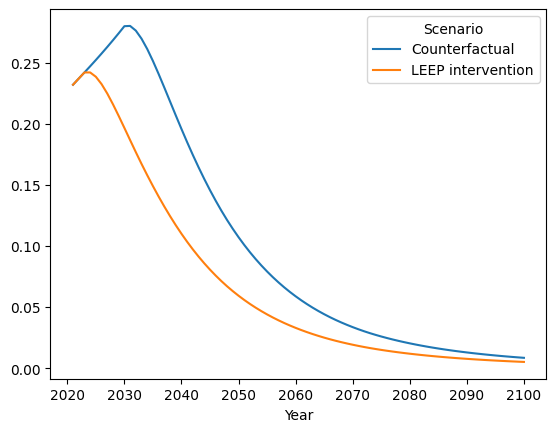

In [25]:
# TODO(drw): Is the Causal version of this plot population-weighted?
_ = number_of_homes_with_lead_paint.sum(axis=1).groupby(["Scenario", "Year"]) \
    .mean().div(number_of_homes.sum(axis=1), level=1).unstack("Scenario").plot()

#### Births in homes with lead paint

In [26]:
births_in_homes_with_lead_paint_counterfactual = pct_of_total_homes_with_lead_paint*births

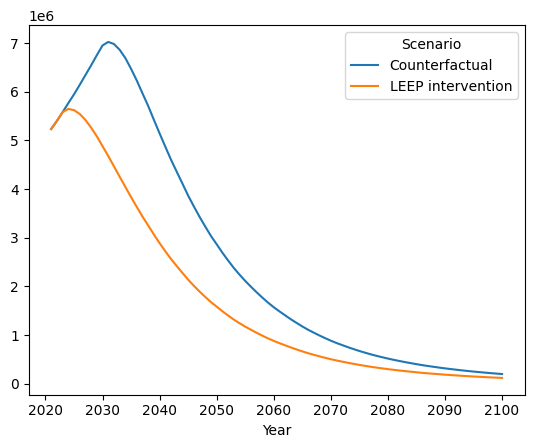

In [27]:
_ = births_in_homes_with_lead_paint_counterfactual.sum(axis=1).groupby(
    ["Scenario", "Year"]).mean().unstack("Scenario").plot()

### Births with averted lead paint exposure vs. counterfactual

In [28]:
births_with_averted_lead_paint_exposure_vs_counterfactual = \
    births_in_homes_with_lead_paint_counterfactual.loc[idx['Counterfactual', :, :], :].droplevel(0) - \
    births_in_homes_with_lead_paint_counterfactual.loc[idx['LEEP intervention', :, :], :].droplevel(
        0)

### Total number of births with averted lead paint exposure

In [29]:
total_number_of_births_with_averted_lead_paint_exposure = \
    births_with_averted_lead_paint_exposure_vs_counterfactual.groupby(
        level=0).sum()

### Total expected number of births with averted lead paint exposure

In [30]:
total_expected_number_of_births_with_averted_lead_paint_exposure = \
    total_number_of_births_with_averted_lead_paint_exposure * \
    probability_of_success

### Number of homes with averted lead paint vs. counterfactual

In [31]:
number_of_homes_with_averted_lead_paint_vs_counterfactual = \
    number_of_homes_with_lead_paint.loc[idx['Counterfactual', :, :], :].droplevel(0) - \
    number_of_homes_with_lead_paint.loc[idx['LEEP intervention', :, :], :].droplevel(
        0)

### Total number of homes with averted lead paint

In [32]:
total_number_of_homes_with_averted_lead_paint = \
    number_of_homes_with_averted_lead_paint_vs_counterfactual.groupby(
        level=0).sum()

### Total expected number of homes with averted lead paint

In [33]:
total_expected_number_of_homes_with_averted_lead_paint = \
    total_number_of_homes_with_averted_lead_paint * \
    probability_of_success

## Benefits

### Income benefit

#### IQ loss per BLL increase

We assume that a 1 ug/dL increase in blood lead level is associated with a 0.5 point decrease in IQ. This is based on research from [Lanphear et al. (2005)](https://ehp.niehs.nih.gov/doi/10.1289/EHP5685), who find that for an individual with a BLL between 2.4 and 10 ug/dL, each 1 μg/dL increase in BLL is associated with an IQ loss of 0.51 points (95% CI: 0.32-0.70). This paper uses a spline/piecewise model to produce unique estimates of this relationship at different blood lead level ranges. The estimate we use in our model is a simplification of this approach in that we assume a constant value and therefore do not account for changes in the relationship between IQ loss and blood lead level across different blood lead levels. The average childhood blood lead levels in our focus countries fall within the 2.4 to 10 μg/dL range, hence our choice of this estimate.

In [34]:
iq_loss_per_bll_increase = pd.Series(sq.norm(0.32, 0.7, lclip=0) @ N)

#### % earnings loss per point of IQ loss

[Attina & Trasande (2013)](https://files.givewell.org/files/DWDA%202009/Interventions/Public_health_regulation/Attina_and_Trasande_2013.pdf) estimate that a one point decrease in IQ loss is associated with a 2% decrease in earnings in LMICs. [Larsen and Sánchez-Triana (2023)](https://www.thelancet.com/journals/lanplh/article/PIIS2542-5196(23)00166-3/fulltext#seccestitle150) also use this estimate to calculate the neuropsychological effects of lead exposure in children in LMICs. Alternative estimates of this effect size in the US include [Grosse et al. (2002)](https://drive.google.com/file/d/19cuIuznN53tLolvOuXrHF9T8zED-BQfE/view?usp=sharing) (2%) and [Salkever (1995)](https://drive.google.com/file/d/1TzToG8MuGpUx3d0LvWhhq4Ys39ubnCMe/view) (1.9% for men and 3.2% for women). GiveWell estimates this effect size at 0.67% for LMICs.

The literature shows varying estimates because cognitive ability affects earnings through multiple channels: it has both a direct effect on earnings, as well as an indirect effect through its effect on years of schooling and employment. Researchers apply different approaches to account for this. 

It would be ideal to have multiple estimates for the effect of earnings on IQ in low-income countries, as the model relies heavily on this single study. To account for uncertainty, we have discounted the estimate used in the Attina and Trasande study by 50%. Thus we assume a single point of IQ loss is associated with a 1% decrease in earnings. This is slightly higher than the GiveWell estimate, but aims to also take into account the estimates from other sources mentioned above.


In [35]:
# TODO(drw): This can't be negative! Check for other normal distribution issues?
pct_earnings_loss_per_point_of_iq_loss = pd.Series(sq.norm(0.007, 0.024, lclip=0, rclip=1
                                                           ) @ N)

#### Earnings impact % from living in a home with lead paint

In [36]:
earnings_impact_pct_from_living_in_a_home_with_lead_paint = \
    increase_in_bll_from_living_in_a_home_with_lead_paint * \
    iq_loss_per_bll_increase * \
    pct_earnings_loss_per_point_of_iq_loss

#### Real growth in income per per capita in LMICs

Our estimate for real growth in income per capita in LMICs (3%) is also provided by the [World Bank](https://perma.cc/F5TW-ZGAX). This value is equal to the average annual growth rate in income per capita in LMICs across the years 1961-2021.

In [37]:
# TODO(drw): Another independent estimate of growth? Uncertainty estimate?
real_growth_in_income_per_capita_in_lmics = 0.03

#### Real GDP per capita (PPP)

Estimates for GDP per capita for each country, as well as its growth rate, are provided by the [World Bank](https://data.worldbank.org/indicator/NY.GDP.PCAP.PP.CD?end=2021&start=1990).

In [38]:
REAL_GDP_PER_CAPITA_PPP_INIT = pd.Series(
    [1645,
     1636,
     1782,
     1571,
     6524,
     5774,
     1309,
     2334,
     8885,
     5998,
     5432,
     5867,
     3875], index=COUNTRIES)

real_gdp_per_capita_ppp = pd.DataFrame(
    np.array(
        [REAL_GDP_PER_CAPITA_PPP_INIT * (1 + real_growth_in_income_per_capita_in_lmics)**(year - YEARS[0])
         for year in YEARS]),
    index=YEARS, columns=COUNTRIES)

#### Years until income benefit starts

In [39]:
# TODO(drw): Categorize these as inputs?
years_until_income_benefit_starts = 15

#### Years until income benefit ends

In [40]:
years_until_income_benefit_ends = 64

#### Real income improved through intervention

In [41]:
# TODO(drw): This assumes all births generate GDP per capita from 15-64, but should it account for mortality?
real_income_improved_through_intervention = pd.DataFrame(
    0.0, index=SAMPLE_YEAR_INDEX, columns=COUNTRIES)

for year in YEARS[years_until_income_benefit_starts:]:
    real_income_improved_through_intervention.loc[idx[:, year], :] = \
        births_with_averted_lead_paint_exposure_vs_counterfactual \
        .loc[idx[:, (year - years_until_income_benefit_ends):(year - years_until_income_benefit_starts)], :] \
        .groupby(level=0).sum() \
        .mul(earnings_impact_pct_from_living_in_a_home_with_lead_paint, axis=0) \
        .mul(real_gdp_per_capita_ppp.loc[year], axis=1) \
        .values

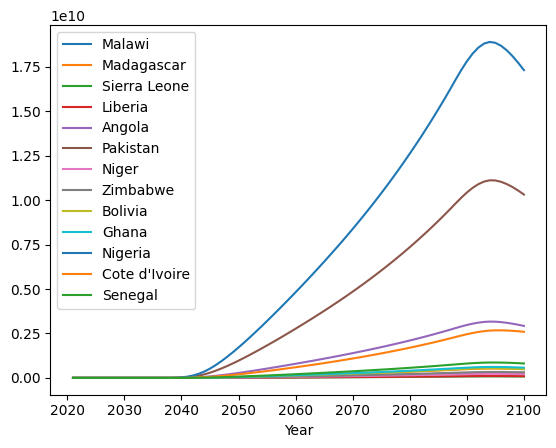

In [42]:
_ = real_income_improved_through_intervention.groupby("Year").mean().plot()

#### Total discounted real income improved through intervention

In [43]:
total_discounted_real_income_improved_through_intervention = \
    real_income_improved_through_intervention.mul(discount_factor, axis=0) \
    .groupby(level=0).sum()

#### Total expected discounted real income improved through intervention

In [44]:
total_expected_discounted_real_income_improved_through_intervention = \
    total_discounted_real_income_improved_through_intervention.mul(
        probability_of_success, axis=0)

### Health benefit

#### Annual health DALYs due to lead exposure (2019)

In [45]:
annual_health_dalys_due_to_lead_exposure_2019 = pd.DataFrame(
    np.array(
        [sq.lognorm(13896, 35975) @ N,
         sq.lognorm(18780, 71201) @ N,
         sq.lognorm(6667, 19198) @ N,
         sq.lognorm(3991, 10876) @ N,
         sq.lognorm(17490, 54720) @ N,
         sq.lognorm(411603, 982017) @ N,
         sq.lognorm(26620, 57310) @ N,
         sq.lognorm(15668, 40949) @ N,
         sq.lognorm(11090, 31897) @ N,
         sq.lognorm(6815, 47049) @ N,
         sq.lognorm(80231, 259028) @ N,
         sq.lognorm(10933, 42558) @ N,
         sq.lognorm(7114, 25100) @ N]).T,
    columns=COUNTRIES)

#### Multiplier due to cardiovascular effect underestimate

Emerging analysis suggests that the effects of lead exposure on cardiovascular outcomes are much higher than what is currently accounted for in the Global Burden of Disease's estimates of the global DALY burden caused by lead exposure. A [2023 World Bank](https://www.thelancet.com/journals/lanplh/article/PIIS2542-5196%2823%2900166-3/fulltext) report suggests that cardiovascular deaths from lead exposure are six times higher than the central estimate in the GBD study. Rethink Priorities also discusses this possibility in its [Global Lead Exposure Report](https://rethinkpriorities.org/publications/global-lead-exposure-report), in which they propose that the true DALY burden attributed to lead exposure is about 30-100% larger than the current GBD estimate. 

Furthermore, IHME has published an [updated (2021) estimate](https://www.jacc.org/doi/10.1016/j.jacc.2022.11.005) for the global burden of health DALYs attributable to lead exposure through cardiovascular disease, which puts the number at 29.7 million (95% UI: -2,780,000-61,200,000). This is 8 million DALYs larger than the 2019 estimate, whilst only accounting for DALYs from cardiovascular disease (whereas the 2019 estimate accounts for DALYs from kidney disease and intellectual disability as well). The 2021 data is not available at the country level, hence we use the 2019 estimates in our model, but this gives us even more reason to believe that the 2019 number is an underestimate of the true DALY burden. Based on this research from the World Bank and Rethink Priorities, new data from IHME, further literature review, and expert input, we use a multiplier of 1.5 to account for additional cardiovascular effects in our estimate of the total DALY burden attributable to lead exposure.

In [46]:
# TODO(drw): This shouldn't be less than 1?
multiplier_due_to_cardiovascular_effect_underestimate = pd.Series(
    sq.lognorm(1, 2.5, lclip=1) @ N)

#### Adjusted annual health DALYs due to lead exposure (2019)

In [47]:
adjusted_annual_health_dalys_due_to_lead_exposure_2019 = \
    annual_health_dalys_due_to_lead_exposure_2019.mul(
        multiplier_due_to_cardiovascular_effect_underestimate, axis=0)

#### Births (2019)

In [48]:
births_2019 = pd.Series(
    [634083,
     872971,
     261970,
     160753,
     1284366,
     6330933,
     1075960,
     484906,
     263006,
     901018,
     7697868,
     903861,
     535968], index=COUNTRIES)

#### Health DALYs due to lead exposure per birth (2019)

Our estimates for the annual burden of health DALYs caused by lead exposure are from the [2019 Global Burden of Disease (GBD) report](https://www.healthdata.org/research-analysis/gbd) published by the Institute for Health Metrics and Evaluation. In our CEA, we use this estimate to calculate the total DALY burden that is attributable to lead exposure for the average individual. The GBD report only takes into account the health effects of lead that occur through cardiovascular disease, kidney disease, and intellectual disability. It fails to account for other health impacts of lead, such as anaemia, growth stunting, preterm births, and mental health problems. As a result, the GBD's estimate likely underestimates the true DALY burden caused by lead exposure.

The 2019 value for this input represents the total burden of health DALYs attributable to lead exposure across _all individuals_ within the 2019 population. The way we use this estimate is a simplification because the majority of the DALY burden in the current (2019) population is a result of historical lead exposure experienced by individuals who are now adults, rather than exposure experienced by children in that birth year. If we had perfect data, we would instead estimate the total DALY burden _explicitly_ for the 2019 birth cohort.

With that said, there are two factors that could make this approximation an overestimate or an underestimate. First, the current number of children who could potentially be exposed to lead has and will continue to increase over time due to population growth (LMIC population has doubled since 1985). So the 2019 burden likely represents DALYs in an adult population that is significantly smaller than today's population of potentially exposed current and future children. This means that predicting DALY burden for the 2019 population may _underestimate_ the effects of current and future lead exposure. Second, older birth cohorts may have had higher average blood lead levels due to exposure to leaded gasoline, which was used to fuel passenger vehicles in the past but has since been phased out. The 2019 estimate of DALY burden includes the adult-onset DALYs from these older birth cohorts who were exposed to leaded gasoline because it represents DALY burden across the entire population. This implies that the 2019 estimate might _overestimate_ the effect of exposure in a given year. These two factors may offset one another to some extent.

In [49]:
# TODO(drw): The actual DALY estimates for births is somewhere in 2019 GBD data?
health_dalys_due_to_lead_exposure_per_birth_2019 = \
    adjusted_annual_health_dalys_due_to_lead_exposure_2019.div(
        births_2019, axis=1)

#### Average childhood BLL (2019)

We access country-level data on average childhood BLL through [LeadPollution.org](https://leadpollution.org/). Data is provided by the [Institute for Health Metrics and Evaluation](https://www.healthdata.org/).

In [50]:
average_childhood_bll_2019 = pd.DataFrame(
    np.array(
        [sq.lognorm(3.8, 5.6) @ N,
         sq.lognorm(3.8, 5.8) @ N,
         sq.lognorm(5, 7.6) @ N,
         sq.lognorm(5.8, 8.6) @ N,
         sq.lognorm(3.4, 5.0) @ N,
         sq.lognorm(3.9, 5.9) @ N,
         sq.lognorm(9.7, 14.5) @ N,
         sq.lognorm(7.4, 11) @ N,
         sq.lognorm(5.2, 7.8) @ N,
         sq.lognorm(2.3, 3.5) @ N,
         sq.lognorm(3.9, 5.9) @ N,
         sq.lognorm(4.1, 6.1) @ N,
         sq.lognorm(3.1, 4.7) @ N]).T, columns=COUNTRIES)

#### Health DALYs per childhood BLL

In [51]:
health_dalys_per_childhood_bll = health_dalys_due_to_lead_exposure_per_birth_2019.div(
    average_childhood_bll_2019, axis=1)

#### Average years until health benefits felt

We estimate that health benefits will be felt, on average, 30 years after lead exposure is averted. The diseases that are responsible for the highest [proportion of the DALY burden attributed to lead exposure](https://ehjournal.biomedcentral.com/articles/10.1186/s12940-022-00914-3/figures/5) are ischemic heart disease, stroke, hypertensive heart disease, and intellectual disability. With the exception of intellectual disability, which has onset during childhood or adolescence, the the majority of conditions caused by lead poisoning tend to onset in adulthood. Because the negative health consequences attributed to lead exposure generally onset later in life, we delay the onset of the health benefits of lead exposure aversion within our CEA.

In [52]:
average_years_until_health_benefits_felt = pd.Series(sq.lognorm(15, 45) @ N)

#### Health DALYs averted through intervention

In [53]:
# TODO(drw): A little confusing that this isn't computed the same way as Income benefit
health_dalys_averted_through_intervention = pd.DataFrame(
    0, index=SAMPLE_YEAR_INDEX, columns=COUNTRIES, dtype=np.float64)

for sample in SAMPLES:
    health_dalys_averted_through_intervention.loc[idx[sample, :], :] = \
        births_with_averted_lead_paint_exposure_vs_counterfactual.loc[idx[sample, :, :], :] \
        .shift(average_years_until_health_benefits_felt[sample].astype(np.int64), axis=0, fill_value=0) \
        .mul(increase_in_bll_from_living_in_a_home_with_lead_paint, level=0, axis=0) \
        .mul(health_dalys_per_childhood_bll, level=0, axis=1)

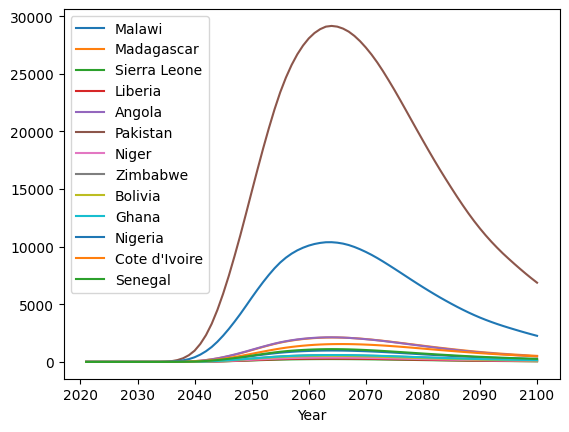

In [54]:
_ = health_dalys_averted_through_intervention.groupby("Year").mean().plot()

#### Total discounted health DALYs averted through intervention

In [55]:
total_discounted_health_dalys_averted_through_intervention = \
    health_dalys_averted_through_intervention.mul(
        discount_factor, axis=0).groupby(level=0).sum()

#### Total expected discounted health DALYs averted through intervention

In [56]:
total_expected_discounted_health_dalys_averted_through_intervention = \
    total_discounted_health_dalys_averted_through_intervention.mul(
        probability_of_success, axis=0)

## DALY-equivalents

### Years of income equivalent to one DALY (moral weight)

We convert income effects into DALY-equivalents using a moral weight. This conversation factor is estimated based on [GiveWell's and IDinsight's](https://blog.givewell.org/2019/12/02/new-research-on-moral-weights/) research on how people make trade-offs between income and health. In its "standard" approach to developing moral weights, GiveWell assumes that 2.5 years of income is roughly as valuable as averting one DALY. We use this assumption in our analysis.

In [57]:
years_of_income_equivalent_to_one_daly_moral_weight = pd.Series(
    sq.lognorm(2, 3) @ N)

### DALY equivalent benefit from income improvement

In [58]:
# TODO(drw): Is PPP GDP equivalent to one year of income?
daly_equivalent_benefit_from_income_improvement = \
    real_income_improved_through_intervention.div(
        real_gdp_per_capita_ppp, level=1, axis=1).div(
        years_of_income_equivalent_to_one_daly_moral_weight, level=0, axis=0)

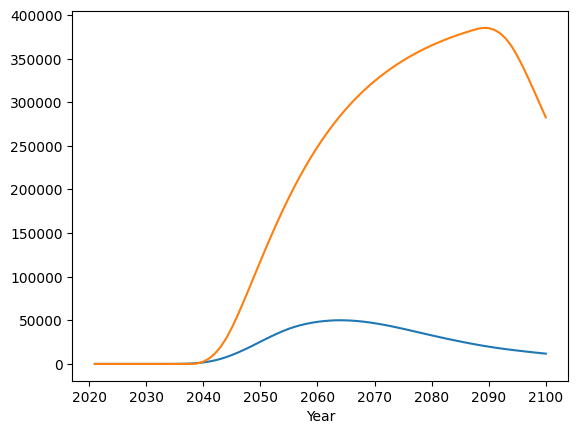

In [59]:
ax = health_dalys_averted_through_intervention.sum(axis=1) \
    .groupby("Year").mean().plot()
_ = daly_equivalent_benefit_from_income_improvement.sum(axis=1) \
    .groupby("Year").mean().plot(ax=ax)

### Total discounted DALY equivalents from income improvement

In [60]:
total_discounted_daly_equivalents_from_income_improvement = \
    daly_equivalent_benefit_from_income_improvement.mul(
        discount_factor, axis=0).groupby(level=0).sum()

### Total expected discounted DALY equivalents from income improvement

In [61]:
total_expected_discounted_daly_equivalents_from_income_improvement = \
    total_discounted_daly_equivalents_from_income_improvement.mul(
        probability_of_success, axis=0)

### Total discounted DALY equivalents averted through successful intervention

In [62]:
total_discounted_daly_equivalents_averted_through_successful_intervention = \
    total_discounted_health_dalys_averted_through_intervention + \
    total_discounted_daly_equivalents_from_income_improvement

### Total expected discounted DALY equivalents averted through successful intervention

In [63]:
total_expected_discounted_daly_equivalents_averted_through_successful_intervention = \
    total_discounted_daly_equivalents_averted_through_successful_intervention.mul(
        probability_of_success, axis=0)

## Costs

### Annual government costs

The primary contributor to government costs is the staff time required to implement/enforce lead paint regulation sooner than in the counterfactual scenario. For many countries we estimate that this is less than one full-time equivalent (FTE), but we round up to at least one FTE. For larger countries (e.g. Nigeria), we estimate up to 5 FTEs. We assume that LEEP programming is only responsible for the government costs that occur in the years that regulation is brought forward.

In [64]:
annual_government_costs = pd.DataFrame(
    np.array(
        [sq.lognorm(3000, 7500) @ N,
         sq.lognorm(3000, 7500) @ N,
         sq.lognorm(3000, 7500) @ N,
         sq.lognorm(3000, 7500) @ N,
         sq.lognorm(4200, 10500) @ N,
         sq.lognorm(9000, 22500) @ N,
         sq.lognorm(3000, 7500) @ N,
         sq.lognorm(4800, 12000) @ N,
         sq.lognorm(6000, 15000) @ N,
         sq.lognorm(5400, 13500) @ N,
         sq.lognorm(15000, 37500) @ N,
         sq.lognorm(9000, 22500) @ N,
         sq.lognorm(7200, 18000) @ N]).T, columns=COUNTRIES)

### Government costs due to LEEP intervention

In [65]:
government_costs_due_to_leep_intervention = pd.DataFrame(
    0, index=SAMPLE_YEAR_INDEX, columns=COUNTRIES, dtype=np.float64)

for year in range(start_of_enforcement_compliance['LEEP intervention'], start_of_enforcement_compliance['Counterfactual']):
    government_costs_due_to_leep_intervention.loc[idx[:,
                                                      year], :] = annual_government_costs.values

### Discount to government costs

We discount government spending that is redirected to lead paint regulation because we expect it would otherwise be spent on less cost-effective activities, making it less counterfactually valuable. Our approach is to discount government costs by 50%. This is an approach that GiveWell has used in the past, for example in its [CEA of pesticide regulation](https://docs.google.com/spreadsheets/d/1bVbJGuzpSldE2RaPH_XieXjnIunXlwkzJ5Q9Ec8GMp4/edit).

In [66]:
# TODO(drw): This shouldn't be greater than 1
discount_to_government_costs = pd.Series(sq.lognorm(0.3, 1.0, rclip=1) @ N)

### Annual government costs counterfactually discounted

In [67]:
annual_government_costs_counterfactually_discounted = \
    government_costs_due_to_leep_intervention.mul(
        discount_to_government_costs, level=0, axis=0)

### Annual charity costs

The estimate for 2021 LEEP costs also accounts for costs incurred while starting up LEEP between August and December 2020. 2022 and 2023 costs are calculated by multiplying LEEP’s total spend by the proportion of LEEP’s total staff time spent on each country. Costs for future years are modelled in LEEP’s budget. We expect programs to last for approximately five to six years, but this varies according to the country. 

In [68]:
annual_charity_costs = pd.read_csv(
    'annual-charity-costs.csv', index_col=0).reindex(YEARS, fill_value=0)

### Total annual costs (time-discounted)

In [69]:
# TODO(drw): "Total" refers to sums elsewhere, not yearly
total_annual_costs_time_discounted = \
    (annual_government_costs_counterfactually_discounted + annual_charity_costs).mul(
        discount_factor, axis=0)

### Total costs (time-discounted)

In [70]:
total_costs_time_discounted = total_annual_costs_time_discounted.groupby(
    level=0).sum()

## Cost effectiveness of successful intervention

### $/DALY-equivalents averted

In [71]:
dollar_per_daly_equivalents_averted = total_costs_time_discounted / \
    total_expected_discounted_daly_equivalents_averted_through_successful_intervention
print(dollar_per_daly_equivalents_averted
      .replace([np.inf, -np.inf], np.nan)
      .dropna(how='all')
      .mean(axis=0).to_string())

Malawi          10.316
Madagascar       7.128
Sierra Leone    30.804
Liberia         30.777
Angola           7.319
Pakistan         1.668
Niger           17.651
Zimbabwe        20.252
Bolivia         23.306
Ghana            7.189
Nigeria          1.355
Cote d'Ivoire    6.523
Senegal         11.667


In [72]:
# TODO(drw): Why is this so different from Causal?
print(total_costs_time_discounted.mean(axis=0).sum() /
      total_expected_discounted_daly_equivalents_averted_through_successful_intervention
      .mean(axis=0).sum())

2.0085556586469138


## Limitations

Below are a list of limitations inherent to the broad estimation strategy we use within this CEA. Limitations specific to our estimation of particular inputs are discussed in the "Inputs” section above. 

- In our CEA, we model the benefits of LEEP programming as explicitly occurring through the channels of health and income. However, the potential benefits of reducing lead paint exposure extend beyond the scope of these two channels and may include reduced mental health burden, decreased healthcare costs, decreased burden to the healthcare system as a whole, and decreases in violent and/or criminal activities. Our model also fails to account for productivity losses due to decreased health outcomes as a result of lead exposure.
- Our model assumes a binary, fixed effect of being born into a home with lead paint (v.s. not being born into a home with lead paint) as the basis for its calculations of the health and income impacts of lead exposure. That is, we do not model a duration-dependent effect of exposure, or account for the possibility of effects due to moving into a home with lead paint later in childhood / life. This is a simplifying assumption that allows our model to be driven by estimates of births in homes with lead paint, rather than having to model the total amount of time that each individual has spent living in a home with lead paint and account for potential differences in dosage-response effects resulting from this. Whilst a simplification, it is possible that the overall effect of this assumption is negligible due to "averaging out” (i.e. for some individuals, exposure due to being born in a home with lead paint may be overestimated if they moved to a home not painted with lead soon after birth, but for others it could be underestimated if they were not born into a home with lead paint, but moved into one shortly after birth). 
- In our calculations of the health and income impacts associated with lead exposure, we assume an additive, linear effect of blood lead on health outcomes. That is, we use measures of "Health DALYs per childhood BLL” and "IQ loss per BLL increase” to drive our health and income benefits calculations. This is a simplification in that it assumes that each BLL increase has an equal marginal impact on health / IQ, which is unlikely to be entirely accurate.
- In accordance with the approach taken in the IHME's [Global Burden of Disease study](https://www.healthdata.org/research-analysis/gbd), we use disability-adjusted life years (DALYs) as the primary unit of measurement for quantifying the health impacts of lead exposure in our model. A DALY is a time-based measure of disease burden. According to the [WHO](https://www.healthdata.org/research-analysis/gbd), "one DALY represents the loss of the equivalent of one year of full health.” As discussed in [this report](https://nccid.ca/publications/understanding-the-measurement-of-global-burden-of-disease/) from the National Collaborating Center for Infectious Diseases, DALYs are constructed using disability weights and age weights, which assert particular assumptions about the relative significance of different non-fatal health outcomes and of different life stages, respectively. For example, years of life lived at very young and very old ages are assigned lower values than a year of healthy life lived around age 20. Disagreement about the relative moral importance of preventing different forms of suffering [is inevitable](https://blog.givewell.org/2008/08/22/dalys-and-disagreement/). Our use of DALYs as the primary metric for measuring health impact is a simplification in that it reflects only one method of weighing the relative importance of different forms of suffering.
- Our model exclusively estimates the proportion of lead paint exposure that occurs within homes. However, there are a variety of additional contexts in which children may be exposed to lead paint, such as in schools, on playgrounds, and in other public spaces. Our model does not account for these additional lead paint exposure pathways.

## Sensitivity analysis

In the process of optimizing our model, we prioritized improving the accuracy of inputs that exhibited the highest levels of sensitivity. These are the inputs for which small value adjustments cause large changes to our final cost-effectiveness estimate.

To determine which inputs our cost-effectiveness estimate is most sensitive to, we performed a basic [sensitivity analysis](https://docs.google.com/spreadsheets/d/1PeNSD1pqSQWF2afvQM0dIj1C-UcRHh4XGU_OmmjstZ4/edit?usp=sharing). In our sensitivity analysis, the upper and lower bound estimates for each input do not represent formal confidence intervals, but are instead best guesses that are based on our team’s intuitive sense of uncertainty about the value of each particular input. The 90% confidence interval around the output estimate, however, is a formal confidence interval calculated using a Monte Carlo simulation that draws from the parameter distributions assumed in the model (see the “Uncertainties” tab/scenario of the [Causal model](https://my.causal.app/models/212624?token=97c447ae91e74281b8032591b190e316)).

Our final cost-effectiveness estimate was most sensitive to the following inputs:

- Annual time discount rate
- % earnings loss per point of IQ loss
- IQ loss per BLL increase
- Average increase in BLL from living in a home with lead paint
- Growth in the paint market (%)
- Years of income equivalent to 1 DALY
- % of new painted homes that use coloured solvent-based paint
- Start of enforcement/compliance (counterfactual and LEEP scenarios)


## Conclusion

We estimate that LEEP’s active paint programs will avert one disability-adjusted life year (DALY) for **$4.49 [$0.82-$12.93]**. These results should be interpreted cautiously, as there is a high degree of uncertainty associated with several inputs that factor into this final result. In particular, the annual time discount rate, % earnings loss per point of IQ loss, IQ loss per BLL increase, average increase in BLL from living in a home with lead paint, and growth in the paint market are inputs to which the final cost-effectiveness estimate is most sensitive to, and that we are highly uncertain about the true value of. It is also important to note that our CEA only estimates the effect of LEEP’s paint programs on health and income; that our estimate of total benefits is limited by our use of DALYs as a unit of measure; and that it fails to account for lead exposure that occurs in contexts outside of the home.

Over time, some uncertainties within this CEA will be reduced as LEEP continues to collect country-specific data on several key inputs – such as LEEP costs, the start date of enforcement/compliance within each target country, and the decline rate in lead market share once enforcement/compliance begins. For example, we plan to collect survey data about paint usage within our program countries in order to inform inputs relating to paint usage, such as the repainting rate. Continuing to collect program-level data will also help us to improve our projections of input estimates in future years. Additionally, the quality of our inputs will improve alongside advancements in research studying the effects of lead paint exposure in LMIC contexts. 
